In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
import PIL
import PIL.Image
import imageio
import imgaug as ia
import random

from pathlib import Path
from numpy import asarray
from imgaug import augmenters as iaa
from keras import backend as K
from keras import layers
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize

In [2]:
train_data_path = '../../sensix_daninhas/dataset_100x100/train'
test_data_path  = '../../sensix_daninhas/dataset_100x100/validation'

img_rows = 100
img_cols = 100
epochs = 300
batch_size = 2
n_channels = 3

In [3]:
num_of_train_samples = len(glob.glob(train_data_path + "/**/*" + ".jpg" , recursive=True))
num_of_test_samples  = len(glob.glob(test_data_path + "/**/*" + ".jpg"  , recursive=True))
print("Train Images : ", num_of_train_samples)
print("Test Images  : ", num_of_test_samples)

Train Images :  199
Test Images  :  49


In [4]:
def random_func(*, percentage: int) -> int:
    '''
    percentage: Valores entre 0 e 100. Caso percentage > _value é retornado true, caso não
    é retornado false
    
    description: Utilizada para definir se a função de pré processamento será utilizada ou
    não. 
    
    return:
    bool
    '''
    _value = random.randint(0, 100)
    if _value < percentage:
        #print(_value)
        return False
    else:
        #print(_value)
        return True
    
#print(random_func(percentage = 50))

In [5]:
#def random_func():
#    _value = random.randint(0, 100)
#    return _value
#    
#print(random_func())

def prepare_dataset(img):
    '''
    img: array que representa a imagem que será modifiada:
    
    description: Utilizada para definir qual função de pré processamento será utilizada,
    cada intervalo representa um tipo de função a ser chamada. 
    [0  10] - imagem não transformada 
    [11 39] - prepare_dataset_func_1(img)
    [40 69] - prepare_dataset_func_2(img)
    [70 ..] - prepare_dataset_func_3(img)
    
    return: array
    O array retornado representa a imagem modificada ou não
    '''
    _choose_func = random_func()
    if _choose_func < 10:
        #print('fun 0')
        return img
    elif _choose_func  >= 10 and _choose_func < 40 :
        _img = prepare_dataset_func_1(img)
        #print('fun 1')
        return _img
    elif _choose_func  >= 40 and _choose_func < 70 :
        _img = prepare_dataset_func_2(img)
        #print('fun 2')
        return _img
    else:
        _img = prepare_dataset_func_3(img)
        #print('fun 3')
        return _img

In [6]:
def prepare_dataset_func_1(img):
    '''
    img: array que representa a imagem que será modificada:
    
    description: Representa efeitos relacionados a coloração da imagem. Nenhuma
    rotação ou aproximação (zoom) é dado. Apenas possui filtros que alteram as 
    caracteristicas gerais das imagens
    
    return: array
    O array retornado representa a imagem modificada
    '''
    img = img.astype('uint8')
    if random_func(percentage = 10):
        seq = iaa.Sequential([
            #iaa.Affine(rotate=(0, 90)),
            #iaa.Crop(percent=(0.1, 0.2)),
            iaa.LinearContrast((1.0, 1.9)),
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            iaa.AdditiveGaussianNoise(scale=(10, 20)),
            #iaa.Crop(percent=(0, 0.2)),
            iaa.AddToBrightness((-30, 30)),
            iaa.AddToHue((-50, 50)),
            #iaa.AllChannelsHistogramEqualization()
        ],
        random_order=True)
        images_aug = seq(image=img)
    else:
        images_aug = img
    
    images_aug = np.expand_dims(images_aug, axis=0)
    images_aug = images_aug.astype('float32')
    return (images_aug)

In [7]:
def prepare_dataset_func_2(img):
    '''
    img: array que representa a imagem que será modifiada:
    
    description: Representa efeitos relacionados a coloração da imagem, porém é 
    uma versão reduzida da prepare_dataset_func_1, aplicando apenas alterações
    nas cores dos canais RGB e modificações leves de contraste.
    
    return: array
    O array retornado representa a imagem modificada
    '''
    img = img.astype('uint8')
    seq = iaa.Sequential([
        iaa.WithChannels(2, [
            iaa.Multiply((0.5, 1.0)),
            iaa.LinearContrast((0.75, 1.25))
        ])
        
    ],
    random_order=True)

    images_aug = seq(image=img)
    images_aug = np.expand_dims(images_aug, axis=0)
    images_aug = images_aug.astype('float32')
    return (images_aug)

In [8]:
def prepare_dataset_func_3(img):
    '''
    img: array que representa a imagem que será modifiada:
    
    description: Representa efeitos relacionados as dimensões das imagens.
    São aplicadas rotações, aproximações (zoom), alteração aleátoria da cor
    do fundo da imagem, translação e rotação de imagens.
    
    return: array
    O array retornado representa a imagem modificada
    '''
    img = img.astype('uint8')
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential([
        sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-45, 45),
        shear=(-16, 16),
        order=[0, 1],
        cval=(0, 255),
        mode=ia.ALL))
    ],
    random_order=True)

    images_aug = seq(image=img)
    images_aug = np.expand_dims(images_aug, axis=0)
    images_aug = images_aug.astype('float32')
    return (images_aug)

In [9]:
def prepare_dataset_func_4(img):
    images_aug = vari_func(img, ch1 = 'green', ch2 = 'red', ch3 = 'blue', v_center=2)
    return (images_aug)

In [10]:
from PIL import Image  
from matplotlib import colors
import PIL  
from numpy import asarray

import matplotlib.pyplot as plt
import numpy as np
import cv2

def vari_func(img, ch1 = 'red', ch2 = 'green', ch3 = 'blue', v_min = 0, v_max = 10, v_center = 5, plot = False):
    '''
    img : array que representa a imagem que será modifiada:
    ch1, ch2, ch3 : canais utilizagos na imagem : Ex: ch1 = red, ch2 = green
    v_min : Representa os intervalos máximos e mínimos, apenas necessário na
    visualização do plot da imagem, que é quando plot é true
    plot : Necessário para plotar ou não a imagem modificada com o seu VARI
    
    description: Efetua o calcuo do (VARI), Índice Resistente à Atmosfera na 
    Região Visível e retorna a imagem modificada pelo VARI.
    
    return: array
    O array retornado representa a imagem modificada
    '''
    _r,_g,_b = cv2.split(img)
    _vari = (_g - _r) / ( _g + _r - _b)
    _vari = np.stack((_vari,)*n_channels, axis=-1)
    if plot:
        _cmap = colors.LinearSegmentedColormap.from_list('', [ch1, ch2, ch3])
        _norm = colors.DivergingNorm(vmin=v_min, vcenter=v_center, vmax=v_max)
        _n_img = plt.imshow(_vari.astype(np.float64), cmap=_cmap, norm=_norm)
        plt.axis('off')
    return _vari

In [27]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   preprocessing_function=prepare_dataset_func_1,
                                   #fill_mode='constant',
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                   )

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  #preprocessing_function=prepare_dataset_func_1,
                                  #fill_mode='constant',
                                  #horizontal_flip=True,
                                  #vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    #save_to_dir='genereted_train',
                                                    #save_prefix = 'train'
                                                    )

validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        #save_to_dir='genereted_val',
                                                        #save_prefix = 'val-'
                                                       )

Found 199 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


In [28]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_rows, img_cols, n_channels), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [30]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=100, 
        verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(train_generator,
                    steps_per_epoch=num_of_train_samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=num_of_test_samples // batch_size,
                    #callbacks=[monitor],verbose=2 # interrompe quando o overfiting começa
         )

Epoch 1/300
99/99 [==============================] - 3s 27ms/step - loss: 0.7930 - accuracy: 0.4965 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/300
99/99 [==============================] - 2s 25ms/step - loss: 0.6813 - accuracy: 0.5696 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/300
99/99 [==============================] - 2s 24ms/step - loss: 0.7023 - accuracy: 0.4444 - val_loss: 0.6930 - val_accuracy: 0.5208
Epoch 4/300
99/99 [==============================] - 2s 25ms/step - loss: 0.7021 - accuracy: 0.4880 - val_loss: 0.6921 - val_accuracy: 0.5208
Epoch 5/300
99/99 [==============================] - 2s 25ms/step - loss: 0.6990 - accuracy: 0.5366 - val_loss: 0.7082 - val_accuracy: 0.4792
Epoch 6/300
99/99 [==============================] - 2s 25ms/step - loss: 0.7046 - accuracy: 0.4663 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/300
99/99 [==============================] - 2s 24ms/step - loss: 0.7618 - accuracy: 0.5867 - val_loss: 0.7241 - val_accuracy: 0.5208
Epoch 

99/99 [==============================] - 2s 25ms/step - loss: 0.1528 - accuracy: 0.9712 - val_loss: 0.8405 - val_accuracy: 0.7917
Epoch 59/300
99/99 [==============================] - 3s 26ms/step - loss: 0.2309 - accuracy: 0.9380 - val_loss: 0.9119 - val_accuracy: 0.8333
Epoch 60/300
99/99 [==============================] - 3s 31ms/step - loss: 0.2672 - accuracy: 0.9213 - val_loss: 0.9076 - val_accuracy: 0.7708
Epoch 61/300
99/99 [==============================] - 4s 37ms/step - loss: 0.1579 - accuracy: 0.9521 - val_loss: 0.7981 - val_accuracy: 0.8125
Epoch 62/300
99/99 [==============================] - 3s 27ms/step - loss: 0.1713 - accuracy: 0.9491 - val_loss: 0.9147 - val_accuracy: 0.7708
Epoch 63/300
99/99 [==============================] - 3s 28ms/step - loss: 0.3408 - accuracy: 0.9042 - val_loss: 1.6973 - val_accuracy: 0.7292
Epoch 64/300
99/99 [==============================] - 3s 27ms/step - loss: 0.2554 - accuracy: 0.9351 - val_loss: 0.8343 - val_accuracy: 0.6875
Epoch 65/300

99/99 [==============================] - 3s 28ms/step - loss: 0.0562 - accuracy: 0.9713 - val_loss: 1.5568 - val_accuracy: 0.8125
Epoch 116/300
99/99 [==============================] - 3s 27ms/step - loss: 0.1622 - accuracy: 0.9670 - val_loss: 1.4541 - val_accuracy: 0.8333
Epoch 117/300
99/99 [==============================] - 3s 27ms/step - loss: 0.1623 - accuracy: 0.9838 - val_loss: 0.7099 - val_accuracy: 0.8333
Epoch 118/300
99/99 [==============================] - 3s 28ms/step - loss: 0.0826 - accuracy: 0.9819 - val_loss: 1.7927 - val_accuracy: 0.7917
Epoch 119/300
99/99 [==============================] - 3s 28ms/step - loss: 0.0543 - accuracy: 0.9854 - val_loss: 2.0928 - val_accuracy: 0.7917
Epoch 120/300
99/99 [==============================] - 3s 27ms/step - loss: 0.2473 - accuracy: 0.9409 - val_loss: 1.3521 - val_accuracy: 0.8125
Epoch 121/300
99/99 [==============================] - 3s 29ms/step - loss: 0.0340 - accuracy: 0.9906 - val_loss: 1.3298 - val_accuracy: 0.8125
Epoch 

Epoch 172/300
99/99 [==============================] - 2s 22ms/step - loss: 0.0970 - accuracy: 0.9721 - val_loss: 1.6758 - val_accuracy: 0.7500
Epoch 173/300
99/99 [==============================] - 2s 23ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 2.3653 - val_accuracy: 0.8125
Epoch 174/300
99/99 [==============================] - 2s 22ms/step - loss: 0.2392 - accuracy: 0.9711 - val_loss: 1.5817 - val_accuracy: 0.7500
Epoch 175/300
99/99 [==============================] - 2s 22ms/step - loss: 0.1824 - accuracy: 0.9816 - val_loss: 0.6942 - val_accuracy: 0.8750
Epoch 176/300
99/99 [==============================] - 2s 22ms/step - loss: 0.0498 - accuracy: 0.9688 - val_loss: 1.7994 - val_accuracy: 0.7500
Epoch 177/300
99/99 [==============================] - 2s 22ms/step - loss: 0.1168 - accuracy: 0.9960 - val_loss: 2.3378 - val_accuracy: 0.8125
Epoch 178/300
99/99 [==============================] - 2s 21ms/step - loss: 0.0101 - accuracy: 0.9882 - val_loss: 3.7596 - val_accuracy:

Epoch 229/300
99/99 [==============================] - 3s 25ms/step - loss: 0.0354 - accuracy: 0.9899 - val_loss: 3.2154 - val_accuracy: 0.7500
Epoch 230/300
99/99 [==============================] - 2s 25ms/step - loss: 0.0158 - accuracy: 0.9901 - val_loss: 3.0410 - val_accuracy: 0.7500
Epoch 231/300
99/99 [==============================] - 2s 24ms/step - loss: 0.0361 - accuracy: 0.9850 - val_loss: 2.3737 - val_accuracy: 0.7292
Epoch 232/300
99/99 [==============================] - 2s 25ms/step - loss: 0.0046 - accuracy: 0.9978 - val_loss: 2.5617 - val_accuracy: 0.7292
Epoch 233/300
99/99 [==============================] - 2s 24ms/step - loss: 0.0257 - accuracy: 0.9952 - val_loss: 4.7205 - val_accuracy: 0.8333
Epoch 234/300
99/99 [==============================] - 2s 24ms/step - loss: 0.0200 - accuracy: 0.9981 - val_loss: 3.2074 - val_accuracy: 0.7083
Epoch 235/300
99/99 [==============================] - 2s 24ms/step - loss: 0.1505 - accuracy: 0.9642 - val_loss: 1.8333 - val_accuracy:

Epoch 286/300
99/99 [==============================] - 3s 26ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 3.9257 - val_accuracy: 0.7500
Epoch 287/300
99/99 [==============================] - 3s 27ms/step - loss: 0.0220 - accuracy: 0.9960 - val_loss: 2.1248 - val_accuracy: 0.7917
Epoch 288/300
99/99 [==============================] - 3s 28ms/step - loss: 0.0716 - accuracy: 0.9874 - val_loss: 3.1582 - val_accuracy: 0.8125
Epoch 289/300
99/99 [==============================] - 3s 26ms/step - loss: 2.2747e-04 - accuracy: 1.0000 - val_loss: 3.5589 - val_accuracy: 0.8333
Epoch 290/300
99/99 [==============================] - 2s 24ms/step - loss: 0.1275 - accuracy: 0.9923 - val_loss: 4.2890 - val_accuracy: 0.7708
Epoch 291/300
99/99 [==============================] - 3s 29ms/step - loss: 0.1265 - accuracy: 0.9838 - val_loss: 2.7809 - val_accuracy: 0.7500
Epoch 292/300
99/99 [==============================] - 3s 25ms/step - loss: 0.0215 - accuracy: 0.9941 - val_loss: 4.3216 - val_accur

In [36]:
Y_pred = model.predict(validation_generator, num_of_test_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
#print(Y_pred)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


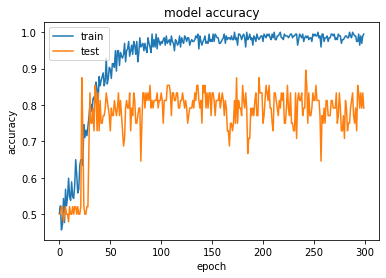

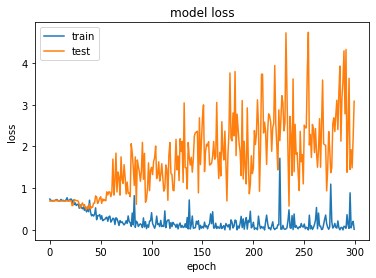

In [37]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
print("Real :       ", validation_generator.classes)
print("Prediction : ", y_pred)
print('Confusion ValueError: could not broadcast input array from shape (1,100,100) into shape (100,100,3)Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Real :        [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Prediction :  [0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 1 1 1 1 1]
Confusion ValueError: could not broadcast input array from shape (1,100,100) into shape (100,100,3)Matrix
[[12 12]
 [10 15]]


In [39]:
print('Classification Report')
target_names = ['daninhas', 'sem_daninhas']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    daninhas       0.55      0.50      0.52        24
sem_daninhas       0.56      0.60      0.58        25

    accuracy                           0.55        49
   macro avg       0.55      0.55      0.55        49
weighted avg       0.55      0.55      0.55        49



In [58]:
model.save("daninhas_prepare_dataset.h5")

In [42]:
image_path = '../../sensix_daninhas/dataset_100x100/validation/sem_daninha'

images = []

for img in os.listdir(image_path):
        img = os.path.join(image_path, img)
        img = image.load_img(img, target_size=(100,100))
        img = image.img_to_array(img)
        #print(img)
        img = np.expand_dims(img, axis=0)
        processed_image = np.array(img, dtype="float")
        images.append(processed_image)
        
images = np.vstack(images)
print(len(images))

25


count_daninha 9
count_sem_daninha 16


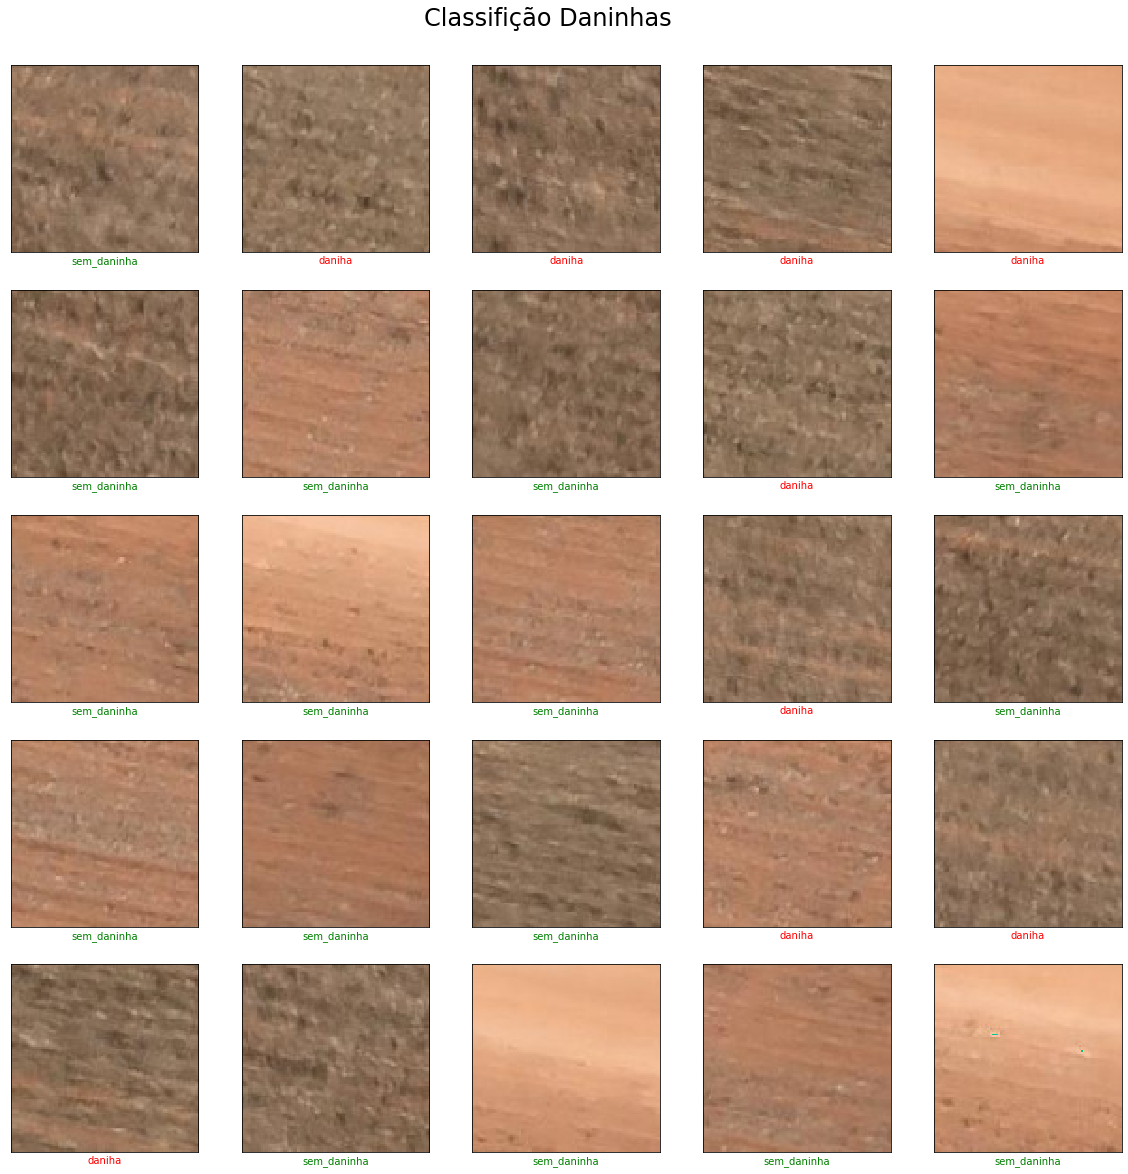

In [43]:
images_data = []
filenames = []
count_daninha = 0
count_sem_daninha = 0
count = 0
pred_result = model.predict(validation_generator, len(images) // batch_size+1)
#print(pred_result)
plt.figure(figsize=(20,20))
grid_size = min(0, len(pred_result))

for filename in os.listdir(image_path):
    images_data.append(pred_result)
    filenames.append(filename)
    plt.subplot(5, 5, count+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[count].astype(np.int32), cmap=plt.cm.binary)
    if pred_result[count][0]> pred_result[count][1]:
        legend_x = plt.xlabel("daniha")
        legend_x.set_color("red")
        count_daninha = count_daninha + 1
        if count >= num_of_test_samples -1:
            break
    else :
        legend_x = plt.xlabel("sem_daninha")
        legend_x.set_color("green")
        count_sem_daninha = count_sem_daninha + 1
    count += 1

print("count_daninha", count_daninha)
print("count_sem_daninha", count_sem_daninha)
plt.suptitle('Classifição Daninhas', y = 0.92, fontsize=24)
plt.show(images_data)